In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.image as mpimg
import os
from sqlalchemy import create_engine

In [5]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [6]:
openalex_snapshot = 'unignhaupka.openalex_aug24_article_reviews_2014_2024'
openalex_baseline_journals_all = 'unignhaupka.openalex_aug24_journals_all_2014_2024'
document_type_snapshot = 'kb_project_openbib.add_document_types_20240831'
scopus_snapshot = 'scp_b_202410.items'
cwts_snapshot = 'unignhaupka.cwts_pub_2024'

In [7]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [10]:
df_doi_2014_2023 = pd.read_sql(f"""
                                SELECT COUNT(DISTINCT(oal.doi)) AS n, is_research
                                FROM {openalex_snapshot} AS oal
                                JOIN {document_type_snapshot} AS dt
                                    ON oal.doi = dt.doi
                                WHERE oal.item_type IN ('article', 'review') AND source_type = 'journal' 
                                    AND publication_year BETWEEN 2014 AND 2023
                                GROUP BY is_research
                                """, 
                                con=engine)

In [11]:
df_doi_2014_2023[df_doi_2014_2023['is_research'] == False].n / df_doi_2014_2023.n.sum()

0    0.106933
Name: n, dtype: float64

In [12]:
df_doi_2014_2023[df_doi_2014_2023['is_research'] == False].n

0    4517879
Name: n, dtype: int64

In [13]:
df_doi_2014_2023.n.sum()

42249505

In [55]:
df_doi_2014_2023_topic = pd.read_sql(f"""
                                      SELECT COUNT(DISTINCT(oal.doi)) AS n, is_research, topic
                                      FROM {openalex_snapshot} AS oal
                                      JOIN {document_type_snapshot} AS dt
                                          ON oal.doi = dt.doi
                                      JOIN {scopus_snapshot} AS scp
                                          ON LOWER(oal.doi) = LOWER(scp.doi)
                                      WHERE oal.item_type IN ('article', 'review') AND oal.source_type = 'journal'
                                          AND publication_year BETWEEN 2014 AND 2023
                                      GROUP BY topic, is_research
                                      """, 
                                      con=engine)

In [56]:
df_doi_2014_2023_topic = df_doi_2014_2023_topic.fillna(value='No topic assigned')

In [57]:
df_doi_2014_2023_topic

,n,is_research,topic
0,238124,False,Health Sciences
1,6079463,True,Health Sciences
2,76141,False,Life Sciences
3,3835366,True,Life Sciences
4,183941,False,Physical Sciences
5,10192138,True,Physical Sciences
6,136905,False,Social Sciences
7,3397992,True,Social Sciences
8,46442,False,No topic assigned
9,123699,True,No topic assigned


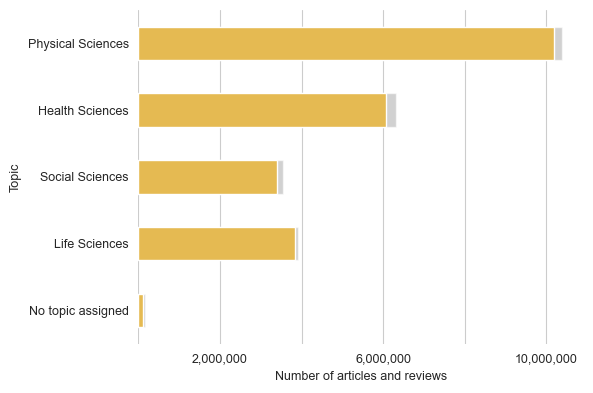

In [64]:
fig, ax = plt.subplots(figsize=(6,4))
plt.box(False)

sns.barplot(data=df_doi_2014_2023_topic.groupby(['topic'])['n'].sum().reset_index(), 
            x='n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2014_2023_topic[df_doi_2014_2023_topic.is_research == True], 
            x='n', 
            y='topic', 
            alpha=1,
            color='#E5BA52',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.set(xlabel='Number of articles and reviews', ylabel='Topic')

plt.tight_layout()

plt.show()
fig.savefig(f'media/dt_topics_openbib.png', format='png', bbox_inches='tight', dpi=500)

In [59]:
df_doi_2014_2023_topic_scopus = pd.read_sql(f"""
                                             SELECT COUNT(DISTINCT(scp.doi)) AS scp_n, topic
                                             FROM {openalex_snapshot} AS oal
                                             JOIN {scopus_snapshot} AS scp
                                                 ON LOWER(oal.doi) = LOWER(scp.doi)
                                             WHERE ('Article' = ANY(scp.item_type) OR 'Review' = ANY(scp.item_type))
                                                 AND oal.source_type = 'journal' AND publication_year BETWEEN 2014 AND 2023
                                             GROUP BY topic
                                             """, 
                                             con=engine)

In [60]:
df_doi_2014_2023_topic_scopus = df_doi_2014_2023_topic_scopus.fillna(value='No topic assigned')

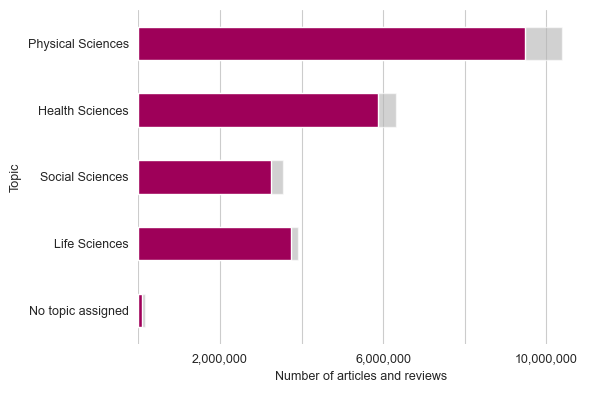

In [63]:
fig, ax = plt.subplots(figsize=(6,4))
plt.box(False)

sns.barplot(data=df_doi_2014_2023_topic.groupby(['topic'])['n'].sum().reset_index(), 
            x='n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2014_2023_topic_scopus, 
            x='scp_n', 
            y='topic', 
            alpha=1,
            color='#9e0059',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.set(xlabel='Number of articles and reviews', ylabel='Topic')

plt.tight_layout()

plt.show()
fig.savefig(f'media/scopus_topics_openbib.png', format='png', bbox_inches='tight', dpi=500)

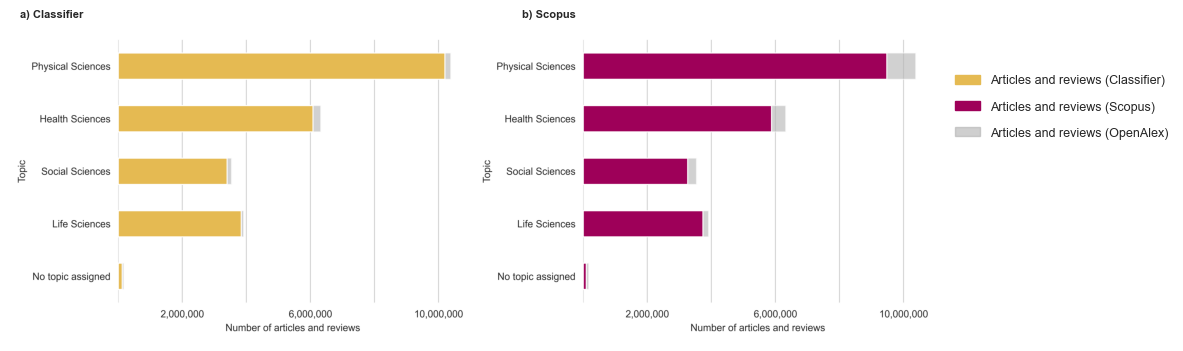

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
filelist =  ['dt_topics_openbib', 'scopus_topics_openbib']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0, hspace=0.15)
plt.text(-2900, -100, 'a) Classifier', size=8, weight='bold')
plt.text(300, -100, 'b) Scopus', size=8, weight='bold')

oal_research_patch = mpatches.Patch(color='#E5BA52', label='Articles and reviews (Classifier)')
scp_research_patch = mpatches.Patch(color='#9e0059', label='Articles and reviews (Scopus)')
not_research_patch = mpatches.Patch(color='#b3b3b3a0', label='Articles and reviews (OpenAlex)')

lgd = fig.legend(handles=[oal_research_patch, scp_research_patch, not_research_patch], frameon=False,
                 bbox_to_anchor=(1.1, 0.65), labelspacing=1.1)

plt.show()
fig.savefig('media/topics_openbib.png', format='png', bbox_inches='tight', dpi=500)

In [27]:
scp_cla_n = pd.read_sql(f"""
                        SELECT COUNT(DISTINCT(dt.doi)) AS n, is_research
                        FROM {document_type_snapshot} AS dt
                        JOIN {scopus_snapshot} AS scp
                            ON LOWER(dt.doi) = LOWER(scp.doi)
                        WHERE ('Article' = ANY(item_type) OR 'Review' = ANY(item_type)) AND (scp.pubyear BETWEEN 2014 AND 2023)
                        GROUP BY is_research
                        """, 
                        con=engine)

In [28]:
scp_cla_n[scp_cla_n['is_research'] == False].n / scp_cla_n.n.sum()

0    0.014733
Name: n, dtype: float64

In [9]:
oal_n = pd.read_sql(f"""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.publication_year 
                    FROM {openalex_snapshot} AS oal
                    JOIN {scopus_snapshot} AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE oal.item_type IN ('article', 'review')  
                        AND oal.source_type = 'journal' AND oal.publication_year BETWEEN 2014 AND 2023
                    GROUP BY oal.publication_year
                    ORDER BY publication_year DESC
                    """, 
                    con=engine)

In [10]:
scp_n = pd.read_sql(f"""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.publication_year
                    FROM {openalex_snapshot} AS oal
                    JOIN {scopus_snapshot} AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE ('Article' = ANY(scp.item_type) OR 'Review' = ANY(scp.item_type))
                        AND oal.source_type = 'journal' AND oal.publication_year BETWEEN 2014 AND 2023
                    GROUP BY oal.publication_year 
                    ORDER BY publication_year DESC
                    """, 
                    con=engine)

In [11]:
dt_n = pd.read_sql(f"""
                   SELECT COUNT(DISTINCT(dt.doi)) AS n, oal.publication_year
                   FROM {document_type_snapshot} AS dt
                   JOIN {scopus_snapshot} AS scp
                       ON LOWER(dt.doi) = LOWER(scp.doi)
                   JOIN {openalex_snapshot} AS oal
                       ON LOWER(dt.doi) = LOWER(oal.doi)
                   WHERE is_research = True
                       AND oal.source_type = 'journal' AND oal.publication_year BETWEEN 2014 AND 2023
                   GROUP BY oal.publication_year 
                   ORDER BY publication_year DESC
                   """, 
                   con=engine)

In [12]:
df_baseline = pd.read_sql(f"""
                           SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                           FROM {openalex_snapshot} AS oal
                           JOIN {scopus_snapshot} AS scp
                               ON LOWER(oal.doi) = LOWER(scp.doi)
                           WHERE oal.source_type = 'journal'
                               AND publication_year BETWEEN 2014 AND 2023
                               AND referenced_works_count != 0 AND oal.cited_by_count != 0
                               AND oal.item_type IN ('article', 'review')
                           GROUP BY publication_year
                           ORDER BY publication_year DESC
                           """, 
                           con=engine)

In [17]:
all_n = pd.read_sql(f"""
                   SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                   FROM {openalex_baseline_journals_all} AS oal
                   JOIN {scopus_snapshot} AS scp
                       ON LOWER(oal.doi) = LOWER(scp.doi)
                   WHERE oal.publication_year BETWEEN 2014 AND 2023
                   GROUP BY publication_year
                   ORDER BY publication_year DESC
                   """, 
                   con=engine)

In [64]:
oal_n['prop'] = (oal_n['n'] / all_n['n']) * 100
scp_n['prop'] = (scp_n['n'] / all_n['n']) * 100
dt_n['prop'] = (dt_n['n'] / all_n['n']) * 100
df_baseline['prop'] = (df_baseline['n'] / all_n['n']) *100

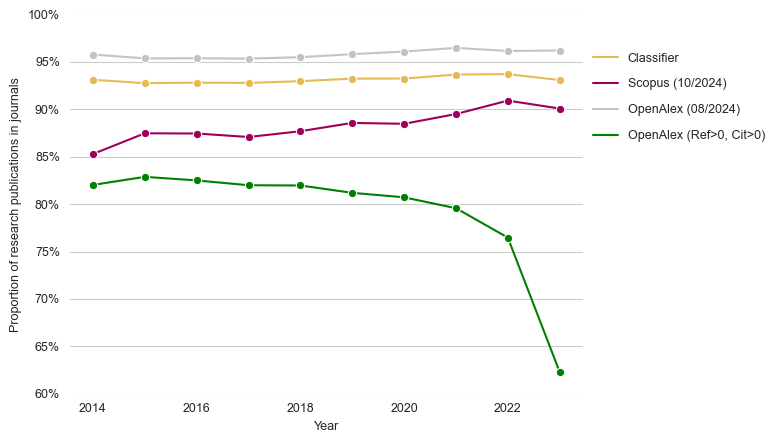

In [69]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_n,
             x='publication_year',
             y='prop',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=scp_n,
             x='publication_year',
             y='prop',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=dt_n,
             x='publication_year',
             y='prop',
             color='#E5BA52',
             marker='o',
             ax=ax)

sns.lineplot(data=df_baseline,
             x='publication_year',
             y='prop',
             color='green',
             marker='o',
             ax=ax)

ax.set_ylim([60, 100])

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Proportion of research publications in journals')

clas_patch = Line2D([0], [0], color='#E5BA52', label='Classifier')
scp_patch = Line2D([0], [0], color='#9e0059', label='Scopus (10/2024)')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (08/2024)')
oal_baseline_patch = Line2D([0], [0], color='green', label='OpenAlex (Ref>0, Cit>0)')

lgd = fig.legend(handles=[clas_patch, scp_patch, oal_patch, oal_baseline_patch], frameon=False,
                 bbox_to_anchor=(1.3, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_scp_comparison_openbib.png', format='png', bbox_inches='tight', dpi=500)